### Forecasting Models on КРС 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



#### Data preparation

In [2]:
df = pd.read_excel("../../Data cleansing/output data/Просуммированные по категориям с доп регрессорами.xlsx")
df.head(5)

,Показатель,Регион,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
0,Верблюды,АКМОЛИНСКАЯ ОБЛАСТЬ,0.00,0.00,0.40,0.00,0.00,0.00,0.09,1.00,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00
1,Верблюды,АКТЮБИНСКАЯ ОБЛАСТЬ,101.98,67.47,374.84,115.59,218.72,14.15,19.77,3.00,...,391.0,126.1,229.10,12.2,24.10,5.7,49.87,63.00,154.3,538.40
2,Верблюды,АЛМАТИНСКАЯ ОБЛАСТЬ,1.00,0.20,51.60,25.40,0.00,61.90,76.87,95.57,...,12.5,16.4,11.60,16.7,15.70,24.0,7.70,6.90,5.4,12.60
3,Верблюды,АТЫРАУСКАЯ ОБЛАСТЬ,213.89,167.70,306.60,164.97,342.57,192.00,43.60,113.03,...,441.9,219.1,487.69,446.9,191.43,133.5,730.34,709.68,537.6,930.28
4,Верблюды,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,0.30,0.00,0.00,1.14,6.12,4.70,4.20,1.80,...,0.0,0.8,0.00,0.0,0.50,0.0,0.00,0.40,0.0,0.00


In [3]:
df_krs = df[df['Показатель'].isin(['КРС', 'Температура', 'Осадки', 'Поголовье: КРС'])]
df_krs.sample(10)

,Показатель,Регион,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
37,КРС,ОБЛАСТЬ ҰЛЫТАУ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.999000e+02,1.794000e+02,4.392500e+02,8.477500e+02,9.950000e+01,5.931000e+02,7.509500e+02,5.070000e+02,2.482500e+02,1.142300e+03
257,Поголовье: КРС,КОСТАНАЙСКАЯ ОБЛАСТЬ,4.068560e+05,4.235990e+05,4.288610e+05,430256.00,4.704070e+05,4.704840e+05,4.552040e+05,4.451290e+05,...,3.882040e+05,3.926100e+05,3.965470e+05,4.161770e+05,4.139900e+05,4.177500e+05,4.084290e+05,3.970790e+05,3.937190e+05,3.923690e+05
174,Температура,КАРАГАНДИНСКАЯ ОБЛАСТЬ,-1.231613e+01,-9.400000e+00,-6.458065e+00,5.40,1.427097e+01,1.973667e+01,2.073548e+01,1.816129e+01,...,-3.719355e+00,8.636667e+00,1.261935e+01,2.063333e+01,2.055161e+01,1.862581e+01,1.048000e+01,5.909677e+00,-2.683333e+00,-9.412903e+00
262,Поголовье: КРС,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,7.867830e+05,8.607460e+05,9.392840e+05,1013296.00,1.046072e+06,1.028143e+06,9.968740e+05,9.773460e+05,...,3.319330e+05,3.380620e+05,3.822090e+05,3.904910e+05,3.652170e+05,3.874970e+05,4.104360e+05,4.039440e+05,3.952790e+05,3.823100e+05
38,КРС,ПАВЛОДАРСКАЯ ОБЛАСТЬ,2.646740e+03,2.934070e+03,3.230620e+03,2731.05,2.830100e+03,3.673180e+03,4.142170e+03,3.487450e+03,...,2.741180e+03,2.948030e+03,3.140460e+03,4.609380e+03,5.306590e+03,4.061350e+03,4.014270e+03,4.697040e+03,5.946290e+03,7.538520e+03
168,Температура,АКМОЛИНСКАЯ ОБЛАСТЬ,-1.249032e+01,-1.019286e+01,-5.870968e+00,4.49,1.457419e+01,2.076333e+01,1.918065e+01,1.652903e+01,...,-4.809677e+00,8.026667e+00,1.069677e+01,2.104333e+01,2.027097e+01,1.733871e+01,1.130000e+01,3.832258e+00,-4.343333e+00,-7.638710e+00
36,КРС,ОБЛАСТЬ ЖЕТІСУ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.392250e+03,2.011370e+03,2.736150e+03,8.860620e+03,1.923470e+03,2.568130e+03,7.223750e+03,6.626000e+03,6.669330e+03,1.241316e+04
239,Осадки,МАНГИСТАУСКАЯ ОБЛАСТЬ,1.320000e+01,9.000000e-01,2.200000e+00,31.70,1.370000e+01,3.000000e-01,3.400000e+00,0.000000e+00,...,3.480000e+01,1.000000e+00,5.140000e+01,1.600000e+00,6.400000e+00,7.000000e-01,1.400000e+00,2.620000e+01,2.670000e+01,2.720000e+01
177,Температура,МАНГИСТАУСКАЯ ОБЛАСТЬ,-4.451613e-01,1.057143e+00,5.835484e+00,10.20,1.742903e+01,2.681333e+01,2.627742e+01,2.617419e+01,...,5.935484e+00,1.611333e+01,1.744839e+01,2.525000e+01,2.665806e+01,2.639355e+01,2.219333e+01,1.342581e+01,7.996667e+00,2.180645e+00
270,Поголовье: КРС,РЕСПУБЛИКА КАЗАХСТАН,5.911878e+06,6.363077e+06,6.812771e+06,7247733.00,7.496735e+06,7.420431e+06,6.969766e+06,6.830351e+06,...,6.792139e+06,7.249217e+06,7.598714e+06,7.834631e+06,8.158970e+06,8.685108e+06,8.597373e+06,8.394724e+06,8.238587e+06,8.051268e+06


In [4]:
# Step 1: Pivot to wide format (each indicator becomes columns of periods)
df_wide = df_krs.pivot(index="Регион", columns="Показатель")

# Step 2: Flatten multi-level columns: ('2015-01', 'КРС') → 'КРС_2015-01'
df_wide.columns = [f"{col[1]}_{col[0]}" for col in df_wide.columns]
df_wide = df_wide.reset_index()

# Step 3: Melt: one row per region-period-indicator
df_melted = df_wide.melt(id_vars="Регион", var_name="indicator_period", value_name="value")

# Step 4: Extract 'Период' and 'Показатель' from the combined column
df_melted["Период"] = df_melted["indicator_period"].str.extract(r"_(\d{4}-\d{2})$")
df_melted["Показатель"] = df_melted["indicator_period"].str.extract(r"^(.+)_\d{4}-\d{2}")

# Step 5: Pivot again to get final modeling format: one row per region+period, one column per indicator
df_krs = df_melted.pivot_table(index=["Регион", "Период"], columns="Показатель", values="value").reset_index()
print(df_krs.groupby("Регион").size().reset_index(name="Количество строк"))
df_krs

                            Регион  Количество строк
0              АКМОЛИНСКАЯ ОБЛАСТЬ               120
1              АКТЮБИНСКАЯ ОБЛАСТЬ               120
2              АЛМАТИНСКАЯ ОБЛАСТЬ               120
3               АТЫРАУСКАЯ ОБЛАСТЬ               120
4   ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ               120
5                     ГОРОД АЛМАТЫ               120
6                     ГОРОД АСТАНА               120
7                    ГОРОД ШЫМКЕНТ                79
8               ЖАМБЫЛСКАЯ ОБЛАСТЬ               120
9    ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ               120
10          КАРАГАНДИНСКАЯ ОБЛАСТЬ               120
11            КОСТАНАЙСКАЯ ОБЛАСТЬ               120
12          КЫЗЫЛОРДИНСКАЯ ОБЛАСТЬ               120
13           МАНГИСТАУСКАЯ ОБЛАСТЬ               120
14                    ОБЛАСТЬ АБАЙ                31
15                  ОБЛАСТЬ ЖЕТІСУ                31
16                  ОБЛАСТЬ ҰЛЫТАУ                31
17            ПАВЛОДАРСКАЯ ОБЛАСТЬ            

Показатель,Регион,Период,КРС,Осадки,Поголовье: КРС,Температура
0,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-01,4455.35,9.8,372560.0,-12.490323
1,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-02,3654.20,9.8,399442.0,-10.192857
2,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-03,4287.08,8.3,425605.0,-5.870968
3,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-04,3923.21,8.8,440023.0,4.490000
4,АКМОЛИНСКАЯ ОБЛАСТЬ,2015-05,3849.70,42.8,444647.0,14.574194
...,...,...,...,...,...,...
2166,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-08,9372.79,0.0,1120067.0,27.874194
2167,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-09,15738.07,0.5,1101103.0,20.766667
2168,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-10,10566.50,13.6,1078583.0,13.200000
2169,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2024-11,11441.98,12.1,1056289.0,6.500000


In [5]:
df_krs.to_excel("Датасет по КРС.xlsx", index=False)

### Multivariate Regression

#### check statistical significance

In [6]:
# Container for collecting regression results
results_list = []

# Loop over each region
for region in df_krs["Регион"].unique():
    df_region = df_krs[df_krs["Регион"] == region][["КРС", "Поголовье: КРС", "Температура", "Осадки"]].dropna()

    if df_region.shape[0] < 10:
        print(f"⚠️ Skipping {region} — insufficient data ({len(df_region)} rows)")
        continue

    y = df_region["КРС"]
    X = df_region[["Поголовье: КРС", "Температура", "Осадки"]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # ✅ Print model summary
    print(f"\n📍 Регион: {region}")
    print(model.summary())

    # ✅ Collect results
    for var in model.params.index:
        results_list.append({
            "Регион": region,
            "Переменная": var,
            "Коэффициент": model.params[var],
            "p-value": model.pvalues[var],
            "R-квадрат": model.rsquared
        })

# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Export to Excel
# results_df.to_excel("krs_linear_regression_results.xlsx", index=False)

print("\n Готово! Результаты экспортированы в 'krs_linear_regression_results.xlsx'")



📍 Регион: АКМОЛИНСКАЯ ОБЛАСТЬ
                            OLS Regression Results                            
Dep. Variable:                    КРС   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     23.37
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           6.63e-12
Time:                        18:24:18   Log-Likelihood:                -958.51
No. Observations:                 120   AIC:                             1925.
Df Residuals:                     116   BIC:                             1936.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const        

#### forecast using MLR

In [7]:
# Forecasting horizon
forecast_horizon = 3

# Container for summary results
results = []

# Loop through each region
for region in df_krs["Регион"].unique():
    if region == "РЕСПУБЛИКА КАЗАХСТАН":
        continue  # ⛔ skip this region
    df_r = df_krs[df_krs["Регион"] == region].sort_values("Период")

    if df_r.shape[0] < forecast_horizon + 12:
        continue  # skip if not enough data

    # Train-test split
    df_train = df_r.iloc[:-forecast_horizon]
    df_test = df_r.iloc[-forecast_horizon:]

    X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
    y_train = df_train["КРС"]
    X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
    y_test = df_test["КРС"]

    # Fit model
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (abs((y_test - y_pred) / y_test).mean()) * 100

    results.append({
        "Регион": region,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R² (Train)": model.score(X_train, y_train)
    })

# Save results
results_df = pd.DataFrame(results)
# results_df.to_excel("mlr_forecast_evaluation_by_region.xlsx", index=False)

results_df


,Регион,RMSE,MAE,MAPE (%),R² (Train)
0,АКМОЛИНСКАЯ ОБЛАСТЬ,625.445715,497.165047,17.088022,0.379584
1,АКТЮБИНСКАЯ ОБЛАСТЬ,3092.518456,3073.109557,61.739264,0.120514
2,АЛМАТИНСКАЯ ОБЛАСТЬ,2521.147144,1942.201617,28.037741,0.144762
3,АТЫРАУСКАЯ ОБЛАСТЬ,662.096720,617.859632,20.378653,0.261023
4,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2314.600480,2243.723817,41.945172,0.213798
5,ГОРОД АЛМАТЫ,8.636686,7.467526,147.238248,0.108763
6,ГОРОД АСТАНА,1.274261,1.051029,34.441186,0.574598
7,ГОРОД ШЫМКЕНТ,222.056770,209.021737,40.896384,0.034153
8,ЖАМБЫЛСКАЯ ОБЛАСТЬ,4726.786626,3298.121081,34.786580,0.142331
9,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2674.620019,1845.171964,26.130508,0.019088


In [8]:
# Calculate and print mean metrics
mean_mape = results_df["MAPE (%)"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_mae = results_df["MAE"].mean()

print(f"Средние метрики по регионам:")
print(f"Средний MAPE: {mean_mape:.2f}%")
print(f"Средний RMSE: {mean_rmse:.2f}")
print(f"Средний MAE: {mean_mae:.2f}")

Средние метрики по регионам:
Средний MAPE: 49.00%
Средний RMSE: 2198.18
Средний MAE: 1704.51


#### regression for Kazakhstan - Поголовье not statistically significant

In [9]:
df_kazakhstan = df_krs[df_krs['Регион'] == 'РЕСПУБЛИКА КАЗАХСТАН'][["КРС", "Поголовье: КРС"]].dropna()
y = df_kazakhstan["КРС"]
X = df_kazakhstan[["Поголовье: КРС"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Print model summary
print("Регион: РЕСПУБЛИКА КАЗАХСТАН")
print(model.summary())

Регион: РЕСПУБЛИКА КАЗАХСТАН
                            OLS Regression Results                            
Dep. Variable:                    КРС   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.687
Date:                Thu, 10 Apr 2025   Prob (F-statistic):             0.0573
Time:                        18:24:19   Log-Likelihood:                -1397.8
No. Observations:                 120   AIC:                             2800.
Df Residuals:                     118   BIC:                             2805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

In [10]:
# from sklearn.linear_model import Ridge

# # Forecasting horizon
# forecast_horizon = 3

# # Container for summary results
# results = []

# # Loop through each region
# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # ⛔ skip this region
#     df_r = df_model[df_model["Регион"] == region].sort_values("Период")

#     if df_r.shape[0] < forecast_horizon + 12:
#         continue  # skip if not enough data

#     # Train-test split
#     df_train = df_r.iloc[:-forecast_horizon]
#     df_test = df_r.iloc[-forecast_horizon:]

#     X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_train = df_train["КРС"]
#     X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_test = df_test["КРС"]

#     # Fit model
#     model = Ridge(alpha=1.0).fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     mape = (abs((y_test - y_pred) / y_test).mean()) * 100

#     results.append({
#         "Регион": region,
#         "RMSE": rmse,
#         "MAE": mae,
#         "MAPE (%)": mape,
#         "R² (Train)": model.score(X_train, y_train)
#     })

#     # Plot actual vs forecast
#     plt.figure(figsize=(6, 3))
#     plt.plot(df_test["Период"], y_test, marker="o", label="Факт")
#     plt.plot(df_test["Период"], y_pred, marker="s", label="Прогноз")
#     plt.title(f"{region} — Прогноз объема КРС на {forecast_horizon} месяца")
#     plt.xlabel("Месяц")
#     plt.ylabel("Объем КРС")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Save results
# results_df = pd.DataFrame(results)
# results_df.to_excel("ridge_forecast_evaluation_by_region.xlsx", index=False)

# print("✅ Готово! Метрики и графики прогноза рассчитаны.")


In [11]:
# # Forecasting horizon
# forecast_horizon = 12

# # Container for summary results
# results = []

# # Loop through each region
# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # ⛔ skip this region
#     df_r = df_model[df_model["Регион"] == region].sort_values("Период")

#     if df_r.shape[0] < forecast_horizon + 12:
#         continue  # skip if not enough data

#     # Train-test split
#     df_train = df_r.iloc[:-forecast_horizon]
#     df_test = df_r.iloc[-forecast_horizon:]

#     X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_train = df_train["КРС"]
#     X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#     y_test = df_test["КРС"]

#     # Fit model
#     model = LinearRegression().fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     mape = (abs((y_test - y_pred) / y_test).mean()) * 100

#     results.append({
#         "Регион": region,
#         "RMSE": rmse,
#         "MAE": mae,
#         "MAPE (%)": mape,
#         "R² (Train)": model.score(X_train, y_train)
#     })

#     # 🟦 Optional: Plot actual vs forecast
#     plt.figure(figsize=(8, 4))
#     plt.plot(df_test["Период"], y_test, marker="o", label="Факт")
#     plt.plot(df_test["Период"], y_pred, marker="s", label="Прогноз")
#     plt.title(f"{region} — Прогноз объема КРС на {forecast_horizon} месяца")
#     plt.xlabel("Месяц")
#     plt.ylabel("Объем КРС")
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Save results
# results_df = pd.DataFrame(results)
# results_df.to_excel("mlr_forecast_evaluation_by_region_12m.xlsx", index=False)

# print("✅ Готово! Метрики и графики прогноза рассчитаны.")


In [12]:
# def sliding_window_evaluation(df_r, forecast_horizon=3, window_count=9):
#     metrics = []

#     # Ensure sorted by time
#     df_r = df_r.sort_values("Период").reset_index(drop=True)

#     for i in range(window_count):
#         # Define train and test split
#         train_end = i + 12  # require 12+ months for training
#         test_start = train_end
#         test_end = test_start + forecast_horizon

#         if test_end > len(df_r):
#             break

#         df_train = df_r.iloc[:train_end]
#         df_test = df_r.iloc[test_start:test_end]

#         X_train = df_train[["Поголовье: КРС", "Температура", "Осадки"]]
#         y_train = df_train["КРС"]
#         X_test = df_test[["Поголовье: КРС", "Температура", "Осадки"]]
#         y_test = df_test["КРС"]

#         # Fit model
#         model = LinearRegression().fit(X_train, y_train)
#         y_pred = model.predict(X_test)

#         # Calculate metrics
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         mae = mean_absolute_error(y_test, y_pred)
#         mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

#         metrics.append({"RMSE": rmse, "MAE": mae, "MAPE": mape})

#     # Aggregate metrics over all sliding windows
#     return pd.DataFrame(metrics).mean().to_dict()

# results = []

# for region in df_model["Регион"].unique():
#     if region == "РЕСПУБЛИКА КАЗАХСТАН":
#         continue  # Optional: exclude a region

#     df_r = df_model[df_model["Регион"] == region][["Период", "КРС", "Поголовье: КРС", "Температура", "Осадки"]].dropna()

#     if df_r.shape[0] < 24:
#         continue  # need enough data for multiple windows

#     metrics = sliding_window_evaluation(df_r)

#     results.append({
#         "Регион": region,
#         "Avg RMSE": metrics["RMSE"],
#         "Avg MAE": metrics["MAE"],
#         "Avg MAPE (%)": metrics["MAPE"]
#     })

# # Save result
# results_df = pd.DataFrame(results)
# results_df.to_excel("sliding_window_forecast_evaluation.xlsx", index=False)

# print("✅ Готово! Средние метрики по скользящим окнам сохранены.")



### Autoregressive Integrated Moving Average (ARIMA)

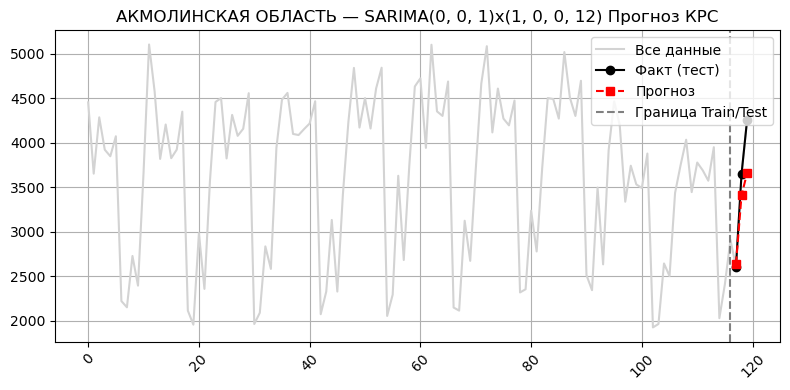

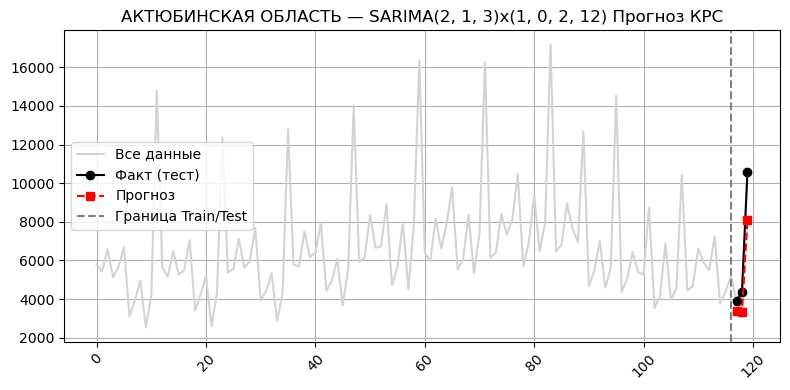

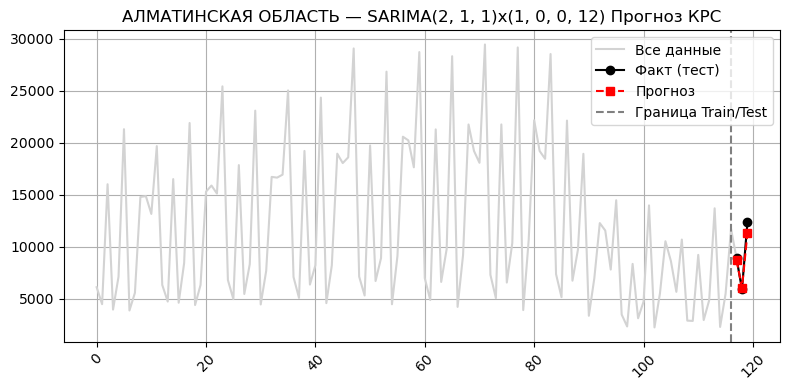

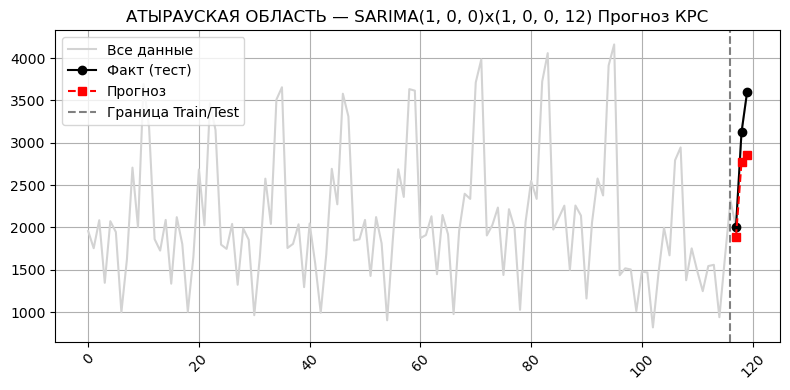

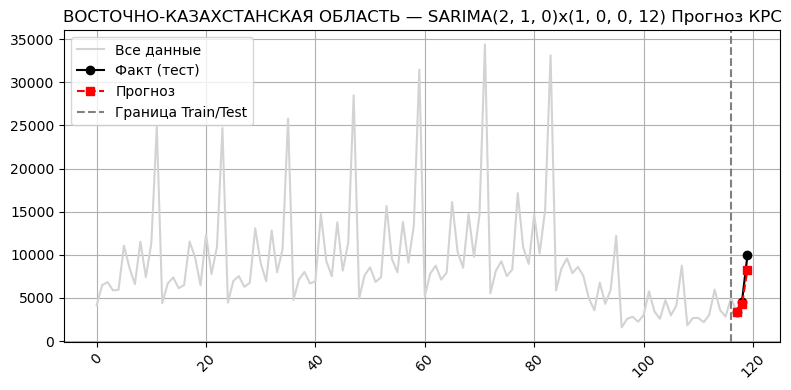

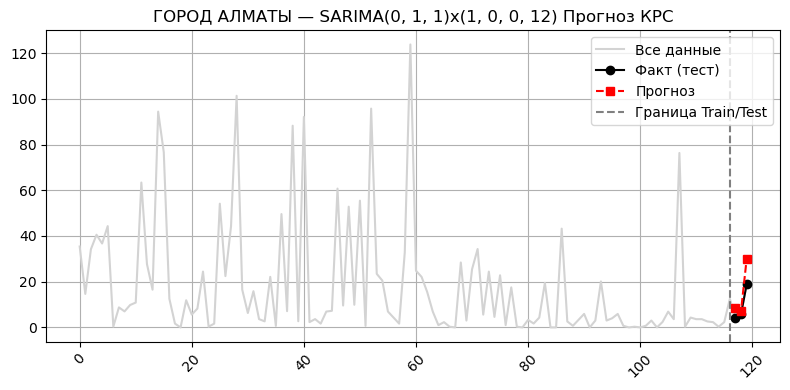

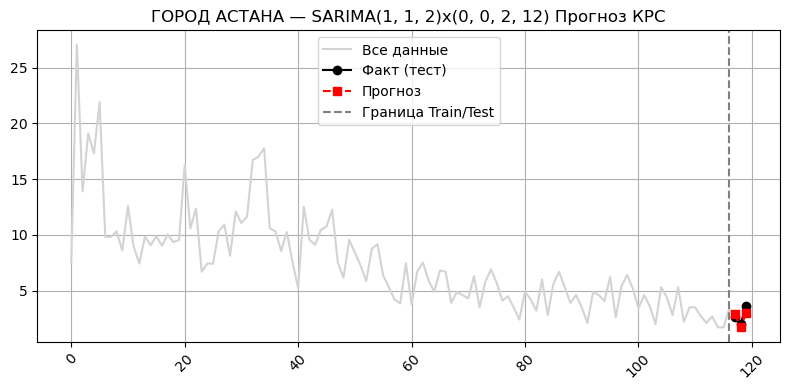

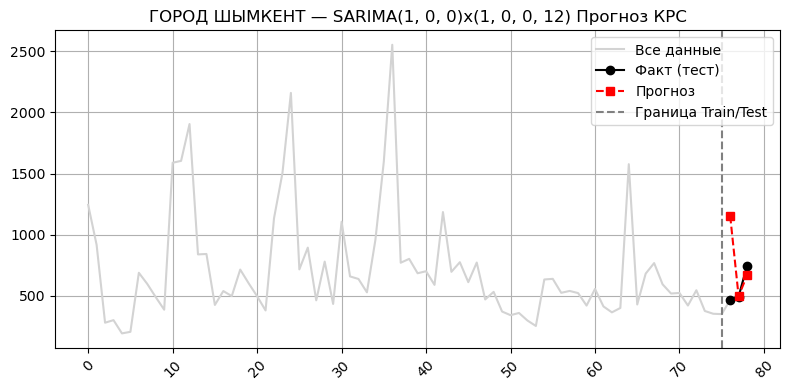

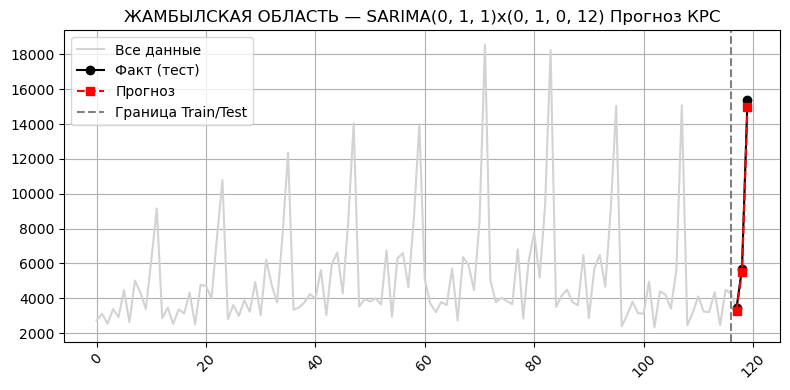

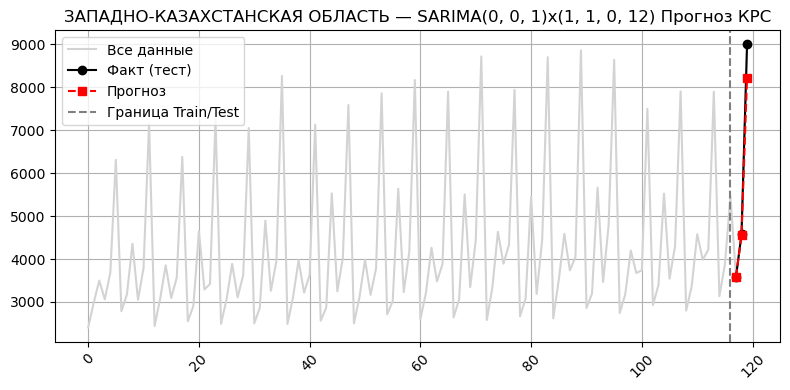

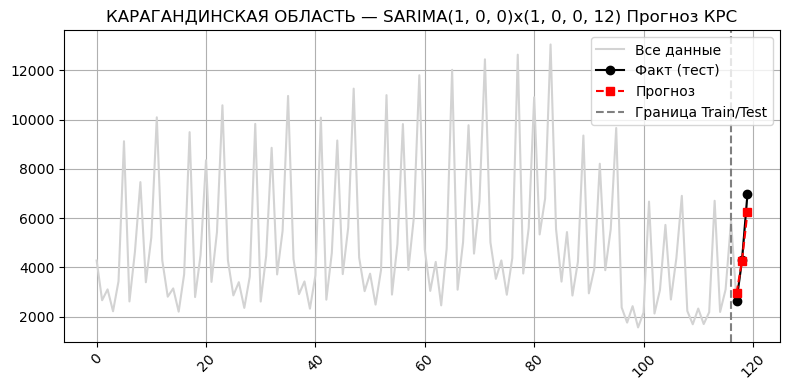

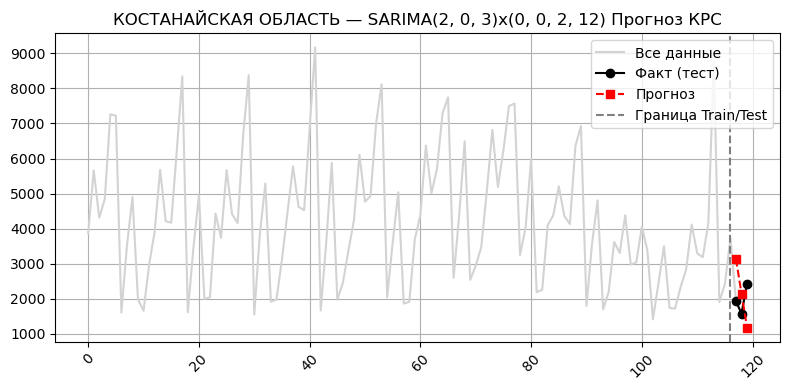

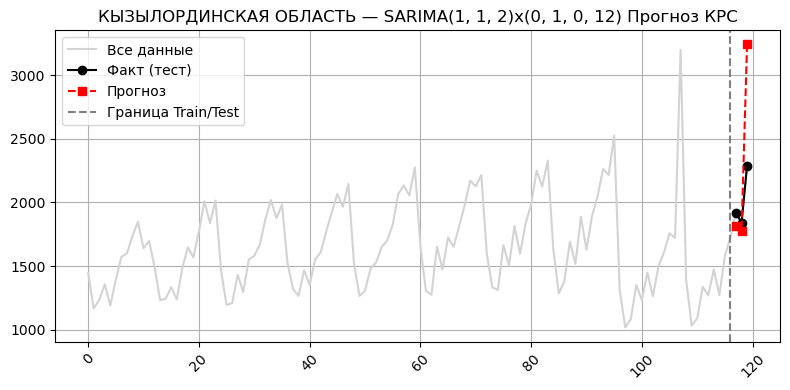

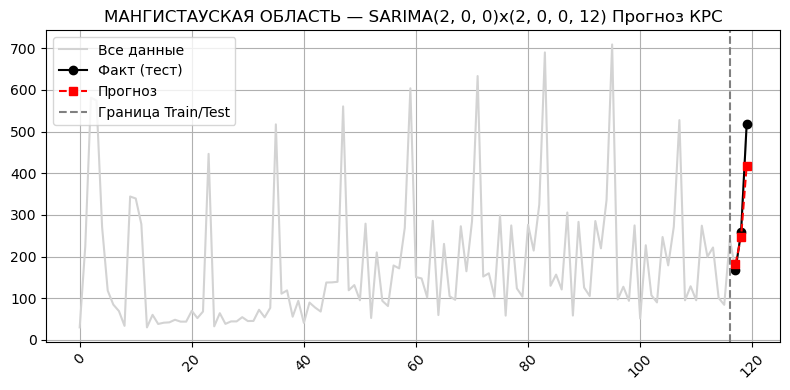

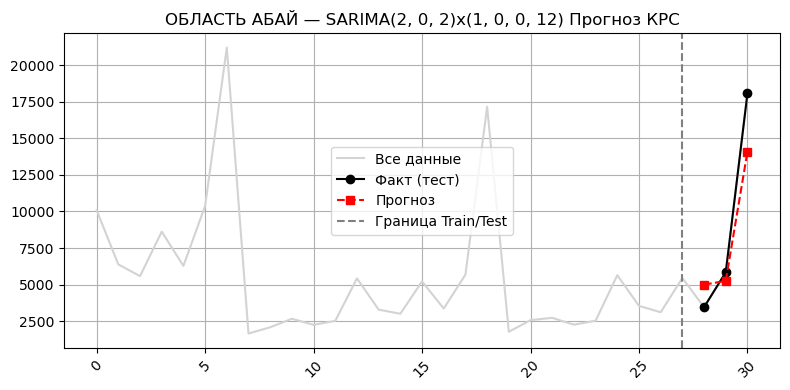

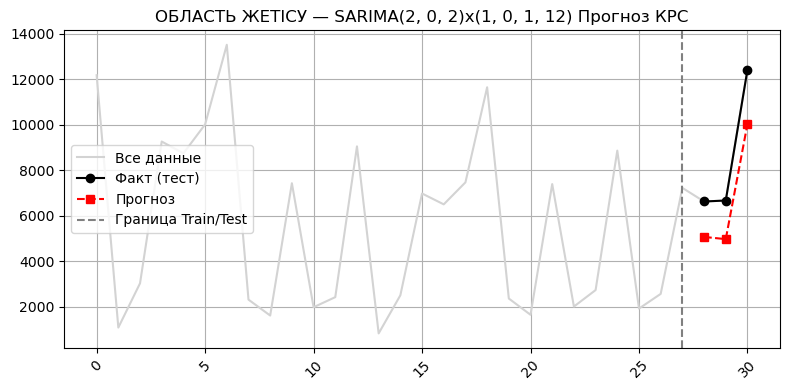

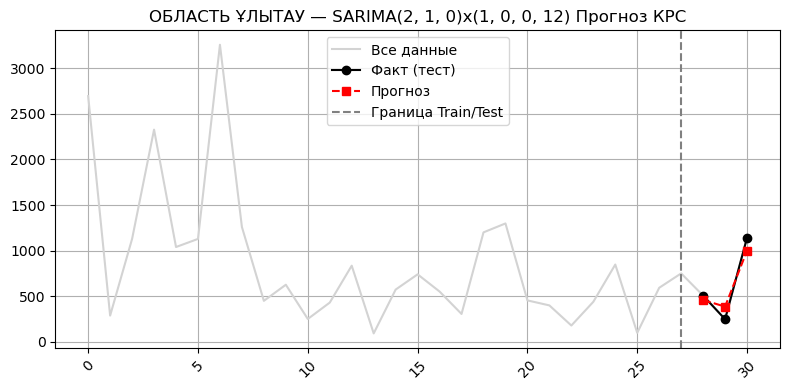

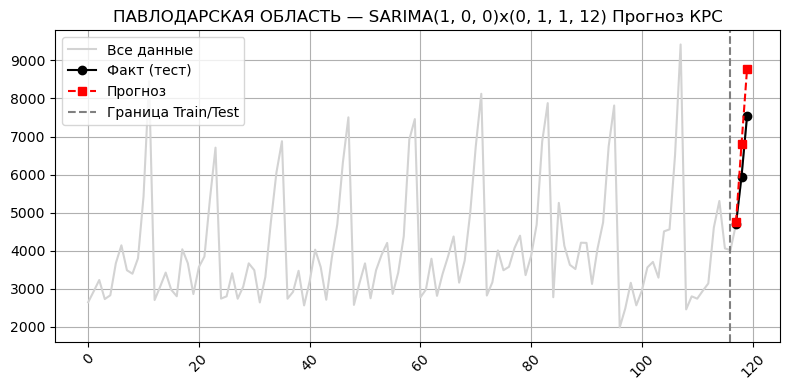

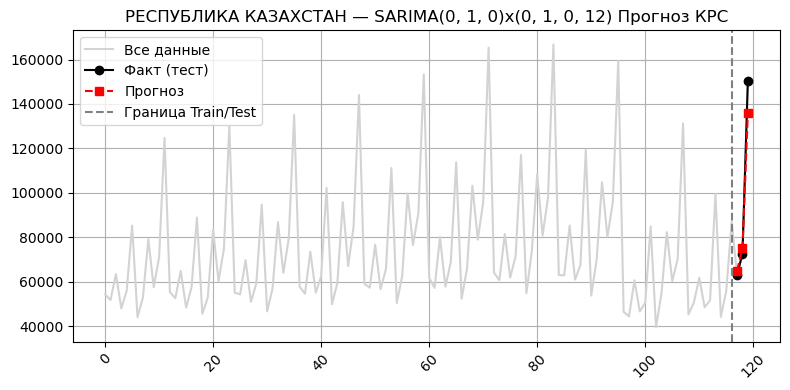

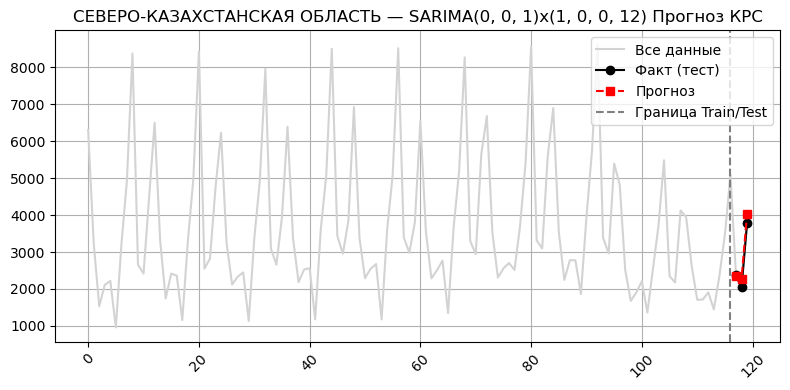

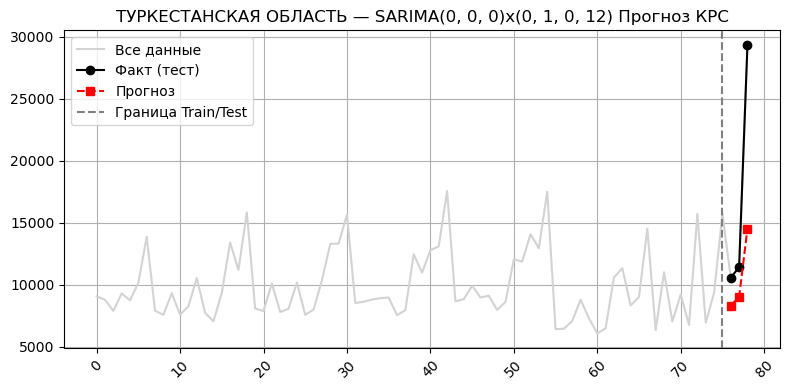

,Регион,SARIMA order,Seasonal order,RMSE,MAE,MAPE (%)
0,АКМОЛИНСКАЯ ОБЛАСТЬ,"(0, 0, 1)","(1, 0, 0, 12)",370.630945,287.979849,7.227363
1,АКТЮБИНСКАЯ ОБЛАСТЬ,"(2, 1, 3)","(1, 0, 2, 12)",1595.131094,1360.425362,20.381480
2,АЛМАТИНСКАЯ ОБЛАСТЬ,"(2, 1, 1)","(1, 0, 0, 12)",636.985040,466.402457,4.383442
3,АТЫРАУСКАЯ ОБЛАСТЬ,"(1, 0, 0)","(1, 0, 0, 12)",475.492771,401.171343,12.510484
4,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,"(2, 1, 0)","(1, 0, 0, 12)",997.450707,689.056125,8.523574
5,ГОРОД АЛМАТЫ,"(0, 1, 1)","(1, 0, 0, 12)",6.925991,5.630612,64.206830
6,ГОРОД АСТАНА,"(1, 1, 2)","(0, 0, 2, 12)",0.417546,0.394064,14.204377
7,ГОРОД ШЫМКЕНТ,"(1, 0, 0)","(1, 0, 0, 12)",400.057156,255.661570,52.761131
8,ЖАМБЫЛСКАЯ ОБЛАСТЬ,"(0, 1, 1)","(0, 1, 0, 12)",266.035201,238.685700,3.207287
9,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,"(0, 0, 1)","(1, 1, 0, 12)",447.773140,267.009770,3.060917


In [13]:
# Container for forecast evaluation results
results = []

# Loop over each region
for region in df_krs["Регион"].unique():
    df_r = df_krs[df_krs["Регион"] == region].sort_values("Период")
    y = df_r["КРС"].reset_index(drop=True)

    if y.isna().sum() > 0 or len(y) < 24:  # Need at least 2 full seasons
        continue

    # Split data
    test_size = 3
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    try:
        # Auto SARIMA model selection
        model = auto_arima(
            y_train,
            seasonal=True,        # Enable SARIMA
            m=12,                 # Season length (12 months)
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        # Forecast
        forecast = model.predict(n_periods=test_size)

        # Evaluation
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Регион": region,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order,
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape
        })

        # Plot actual vs forecast
        plt.figure(figsize=(8, 4))
        plt.plot(y.index, y, color="lightgray", label="Все данные")
        plt.plot(y_test.index, y_test, marker="o", color="black", label="Факт (тест)")
        plt.plot(y_test.index, forecast, marker="s", linestyle="--", color="red", label="Прогноз")
        plt.axvline(len(y_train) - 1, color="gray", linestyle="--", label="Граница Train/Test")
        plt.title(f"{region} — SARIMA{model.order}x{model.seasonal_order} Прогноз КРС")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в {region}: {e}")

# Save results to Excel
results_df = pd.DataFrame(results)
results_df
# results_df.to_excel("sarima_forecast_evaluation_all_regions.xlsx", index=False)


In [14]:
# Calculate and print mean metrics
mean_mape = results_df["MAPE (%)"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_mae = results_df["MAE"].mean()

print(f"Средние метрики по регионам:")
print(f"Средний MAPE: {mean_mape:.2f}%")
print(f"Средний RMSE: {mean_rmse:.2f}")
print(f"Средний MAE: {mean_mae:.2f}")

Средние метрики по регионам:
Средний MAPE: 19.19%
Средний RMSE: 1435.67
Средний MAE: 1112.86
